# PyMC3 简介

本文记录更多的PyMC3语法和变量，以及从贝叶斯角度思考如何对系统建模的方法。还包含用于评估贝叶斯模型拟合优度的技巧和数据可视化技术。

在PyMC3中，我们通常在Model对象的上下文中处理模型中所需的所有变量。

In [1]:
import pymc3 as pm

with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0)
    data_generator = pm.Poisson("data_generator", parameter)

在给定Model的上下文内创建的任何变量都将自动分配给该模型。如果尝试在模型上下文之外定义变量，则会收到错误消息。

通过使用with和已经创建的模型对象的名称，我们可以继续在同一模型的上下文中工作。

In [2]:
with model:
    data_plus_one = data_generator + 1

一旦定义了模型上下文之外的相同变量，就可以对其进行检查，但是要定义更多模型能识别的变量，它们必须要位于上下文中。

In [3]:
parameter.tag.test_value

array(0.69314718)

分配给模型的每个变量都将使用其自己的名称（第一个字符串参数）进行定义（后面有进一步介绍）。要创建一个名称与以前使用的名称相同的模型对象，我们只需要再次运行第一个代码块即可。

In [4]:
with pm.Model() as model:
    theta = pm.Exponential("theta", 2.0)
    data_generator = pm.Poisson("data_generator", theta)

我们还可以定义一个完全独立的模型。请注意，我们可以随意命名模型，因此，如果我们不想覆盖旧模型，则只需创建另一个模型即可。

In [5]:
with pm.Model() as ab_testing:
    p_A = pm.Uniform("P(A)", 0, 1)
    p_B = pm.Uniform("P(B)", 0, 1)

当向模型中添加变量时，PyMC3PyMC3在内部会进行转换，以修改变量在其中采样的空间（当我们开始对模型进行实际采样时）。这是一个内部特征，有助于使我们的样本收敛到后验分布，并有助于改善结果。

所有PyMC3变量都有一个初始值（即测试值）。使用之前相同的变量：

In [6]:
print("parameter.tag.test_value =", parameter.tag.test_value)
print("data_generator.tag.test_value =", data_generator.tag.test_value)
print("data_plus_one.tag.test_value =", data_plus_one.tag.test_value)

parameter.tag.test_value = 0.6931471824645996
data_generator.tag.test_value = 0
data_plus_one.tag.test_value = 1


test_value仅用于模型，作为用于如果没有指定其他开始采样的起点。采样不会改变它。通过为testval参数指定值，可以在创建变量时更改此初始状态。

In [7]:
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0, testval=0.5)

print("\nparameter.tag.test_value =", parameter.tag.test_value)


parameter.tag.test_value = 0.5


如果使用的是较不稳定的先验条件（可能需要更好的起点），这可能会有所帮助。

PyMC3与两种编程变量有关：随机变量和确定性变量。

- 随机变量是不确定的变量，即，即使知道变量参数和组件的所有值，它也仍然是随机的。包括Poisson，DiscreteUniform以及Exponential类的实例。
- 确定性变量是指已知变量参数和成分就不是随机的变量。起初这可能会造成混淆：快速的检查方式是，如果我知道变量foo的所有组成变量，我就可以确定foo值是什么。

我们将在下面详细说明。

初始化随机变量需要一个name参数，以及特定于类的其他参数。例如：

```Python
some_variable = pm.DiscreteUniform("discrete_uni_var", 0, 4)
```

其中0、4是DiscreteUniform特定的随机变量的下限和上限。[PyMC3文档](https://pymc-devs.github.io/pymc3/api.html)包含随机变量的具体参数。（在jupyter中可以使用??查看）

name属性用于稍后在分析中检索后验分布，因此最好使用描述性名称。通常，用Python变量的名称作name。

对于多变量问题，不是创建随机变量的Python数组，而是在对随机变量的调用中用shape关键字来创建（独立）随机变量的多变量数组。像一个数组一样使用它时，该数组的行为类似于NumPy数组

shape参数还解决了可能存在想建模许多变量$\beta_i, \; i = 1,...,N$的烦人的情况。它不是为每个名称创建任意的名称和变量，例如：

```Python
beta_1 = pm.Uniform("beta_1", 0, 1)
beta_2 = pm.Uniform("beta_2", 0, 1)
```

而是将它们包装到一个变量中：

```Python
betas = pm.Uniform("betas", 0, 1, shape=N)
```

对确定性变量，我们可以像创建随机变量一样创建。我们只需在PyMC3中调用Deterministic类，然后传递给函数我们所需的：

```Python
deterministic_variable = pm.Deterministic("deterministic variable", some_function_of_variables)
```

我们可以将 some_deterministic_var对象视为变量而不是Python函数。

调用pymc3.Deterministic是创建确定性变量的最直接方法，但不是唯一的方法。基本运算，例如加法，指数等都可以隐式地创建确定性变量。例如，以下运算返回确定性变量：

In [8]:
with pm.Model() as model:
    lambda_1 = pm.Exponential("lambda_1", 1.0)
    lambda_2 = pm.Exponential("lambda_2", 1.0)
    tau = pm.DiscreteUniform("tau", lower=0, upper=10)

new_deterministic_variable = lambda_1 + lambda_2

如果我们希望通过采样实际跟踪deterministic变量，则需要使用构造函数将其显式定义为命名变量。

deterministic变量的使用在1-bayesian-intro的文本消息示例中可以看到。λ ：

$\lambda = 
\begin{cases}\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}$

在PyMC3代码中：

In [9]:
import numpy as np

n_data_points = 5  # in CH1 we had ~70 data points
idx = np.arange(n_data_points)
with model:
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

显然，如果 τ，λ1 和 λ2 是已知的，那么 λ就是完全已知的，因此它是确定性变量。switch函数相当于if else，此函数来自theano程序包，稍后对其有讨论。

在deterministic变量内部，传入的随机变量的行为类似于标量或NumPy数组（如果是多变量）。只要维度在我们的计算中匹配，我们就可以对它们进行任何操作。

例如，运行以下命令：

```Python
def subtract(x, y):
    return x - y

stochastic_1 = pm.Uniform("U_1", 0, 1)
stochastic_2 = pm.Uniform("U_2", 0, 1)

det_1 = pm.Deterministic("Delta", subtract(stochastic_1, stochastic_2))
```

是完全有效的PyMC3代码。但是，在这里说我们的表达式的行为类似于NumPy数组并不是很诚实。主要问题是我们正在制作的表达式必须与theano张量兼容。随意定义组成模型所需的任何函数。但是，如果需要进行任何需要NumPy函数的类似数组的计算，请确保使用它们在theano中的等效项。

下面稍微补充一点Theano 。

PyMC3完成的大部分繁重工作都由theano包来解决。theano中的表示法与NumPy非常相似。它还支持NumPy的许多熟悉的计算元素。但是，NumPy是直接执行计算（例如在运行a + b时），而theano会建立一个“计算图”来跟踪您要对元素a和b进行运算的情况。仅当使用theano eval()表达式时，才进行计算（即theano 是lazy的）。构建计算图后，我们可以执行各种数学优化，通过autodiff计算梯度，将整个图编译为C以机器速度运行，也可以编译为在GPU上运行。PyMC3基本上是theano用于各种概率分布的符号表达式的集合，这些符号表达式被组合到一个构成整个模型对数概率的大计算图上，并且是使用该图来计算概率和梯度的推理算法的集合。出于实际情况考虑，这意味着为了建立某些模型，我们有时必须使用theano。

让我们写一些涉及theano计算的PyMC3代码。

In [10]:
import theano.tensor as tt

with pm.Model() as theano_test:
    p1 = pm.Uniform("p", 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    
    assignment = pm.Categorical("assignment", p)

在这里，我们使用theano的stack()函数的方式与使用NumPy的堆叠函数方式相同：将我们两个单独的变量p1和组合p2为一个2元素向量。如果我们传递NumPy数组p1，p2给它，随机的categorical变量不明白我们的意思，因为他们都是theano变量。像这样堆叠它们，将它们组合成一个theano变量，我们可以将其用作两个类别的互补概率对。

关于theano，可以查看其[文档](http://deeplearning.net/software/theano/library/)。不过根据[维基百科的介绍](https://zh.wikipedia.org/wiki/PyMC3)，theano于2017年宣布计划停止开发之后，PyMC3团队评估采用TensorFlow Probability作为计算后端，但是在2020年决定接管Theano的开发。并在2021年1月将绝大部分的Theano-PyMC代码重造，增加了通过JAX编译。PyMC团队计划以新名字发行修订后的计算后端并继续开发PyMC3，使用方式和之前仍然保持一致。

现在回到模型上。看看如何在模型中包括观察值。

现在我们已经可以指定先验条件。例如，我们可以问和回答这样的问题--“λ1先验分布什么样？”

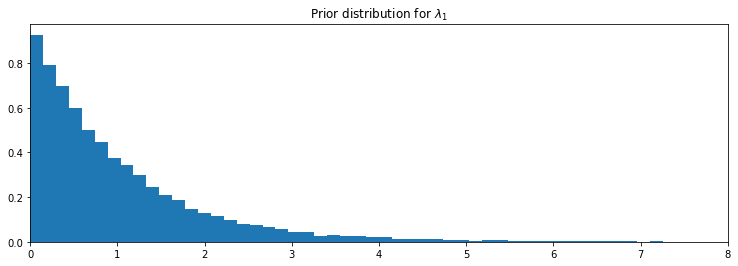

In [14]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
figsize(12.5, 4)


samples = lambda_1.random(size=20000)
plt.hist(samples, bins=70, density=True, histtype="stepfilled")
plt.title("Prior distribution for $\lambda_1$")
plt.xlim(0, 8);

为了在第一章的符号中说明这一点，尽管这是对符号的稍微滥用，我们已经指定了 P（A）。我们的下一个目标是包括作为数据/证据/观察 的X 进入我们的模型。

PyMC3随机变量具有关键字参数observed。关键字observed的作用很简单：将变量的当前值固定为给定数据，通常为NumPyarray或pandas DataFrame。例如：

In [15]:
data = np.array([10, 5])
with model:
    fixed_variable = pm.Poisson("fxd", 1, observed=data)
print("value: ", fixed_variable.tag.test_value)

value:  [10  5]


就是我们将数据包含到模型中的方式：将随机变量初始化为具有固定值。

为了完成我们的文本消息示例，我们将PyMC3变量observations固定到观察到的数据集。

In [16]:
# We're using some fake data here
data = np.array([10, 25, 15, 20, 35])
with model:
    obs = pm.Poisson("obs", lambda_, observed=data)
print(obs.tag.test_value)

[10 25 15 20 35]


下面进入**建模方法**。

贝叶斯建模的一个很好的开始是*思考如何生成数据*。将自己置于一个无所不知的位置，尝试想像你创建数据集。

在上一章中，我们研究了文本消息数据。我们首先问一下我们的观察结果是如何产生的：

1. 我们首先思考“描述此计数数据的最佳随机变量是什么？” 泊松随机变量是一个很好的候选者，因为它可以表示计数数据。因此，我们对从Poisson分布中采样的短信数进行建模。
2. 接下来，我们认为，“好吧，假设短信是泊松分布的，那么泊松分布需要什么？” 好吧，泊松分布有一个参数λ。
3. 我们知道吗 λ？答案是No。实际上，我们怀疑有两个 λ值，一个用于较早的行为，一个用于较晚的行为。我们不知道何时切换行为，但可以设置切换点τ。
4. 两个λs的良好分布是什么 ？指数是好的，因为它将概率分配给正实数。不过，好吧，指数分布也有一个参数α。
4. 我们知道参数α 可能是什么? 答案还是No。 这时候, 我们可能继续分配一个分布给 α，但最好是一旦达到一定程度的无知就停止： 我们对λ有一些先验的认知，（“它可能会随时间变化”，“可能在10到30之间变化”等），但我们对α并没有什么信念 。因此，最好到此为止。 那么α取什么值好呢 ？我们认为λs在10到30之间，所以如果我们设置 α很低（对应于较高值较高概率），就没有很好地反映我们的先验情况。同样，alpha值过高也会错过我们先前的信念。一个关于α的好主意是 反映我们的信念是设定值，以便给定 α， λ等于我们观察到的平均值。上一章已对此进行了说明。
6. 我们对τ何时可能发生没有专家意见 。所以我们假设τ 来自整个时间范围内的离散均匀分布。

下面，我们对此进行了图形化可视化，其中箭头表示parent-child关系。（由[Daft Python库](http://daft-pgm.org/)提供）

![](pictures/7J30oCG.png)

PyMC3和其他概率编程语言已被设计用来讲述这些数据生成的故事。

> 概率编程将解开数据的叙述性解释，这是业务分析的圣旨之一，也是科学说服力的无名英雄。人们从故事的角度来思考-因此，轶事的无理力量会推动决策的进行，无论是否有根据。但是现有的分析方法在很大程度上无法提供这种说法。相反，数字似乎是凭空出现的，几乎没有人类在权衡其选择时所喜欢的因果关系。

有趣的是，我们可以通过重述故事来创建新的数据集。例如，如果我们颠倒上述步骤，则可以模拟数据集的可能实现。

1.通过从DiscreteUniform （0 ，80 ）采样来指定用户的行为何时切换  

In [17]:
tau = np.random.randint(0, 80)
print(tau)

26


2.从 指数（α ） 分配给出 λ1 和 λ2 

In [18]:
alpha = 1./20.
lambda_1, lambda_2 = np.random.exponential(scale=1/alpha, size=2)
print(lambda_1, lambda_2)

98.16305093210657 5.295473858066205


3.τ前几天 通过从Poi （λ1）采样来表示用户收到的SMS计数 ，τ后几天从 Poi （λ2）。例如：

In [19]:
data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size = 80 - tau)]

4.绘制人工数据集：

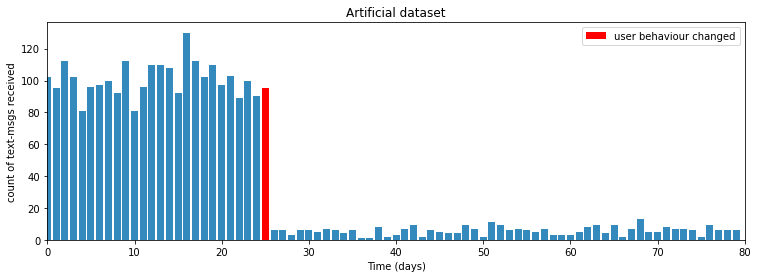

In [20]:
plt.bar(np.arange(80), data, color="#348ABD")
plt.bar(tau-1, data[tau - 1], color="r", label="user behaviour changed")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Artificial dataset")
plt.xlim(0, 80)
plt.legend();

可我们的虚构数据集看起来不像我们观察到的数据集：可能性确实很小。PyMC3的引擎旨在查找良好的参数，λs，τ，从而最大程度地提高了这种可能性。

生成人工数据集的能力是我们建模的一个有趣的side effect，我们将看到这种能力是贝叶斯推断的一种非常重要的方法。我们在下面生成更多数据集：

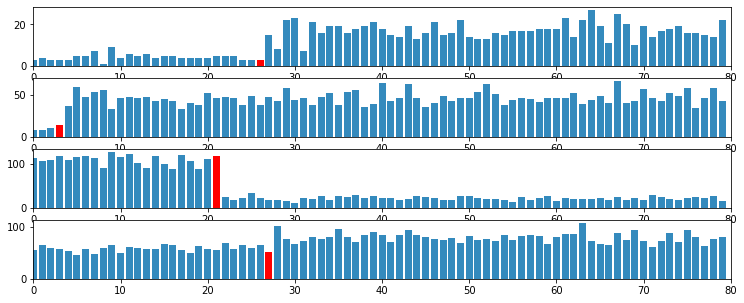

In [21]:
def plot_artificial_sms_dataset():
    tau = stats.randint.rvs(0, 80)
    alpha = 1./20.
    lambda_1, lambda_2 = stats.expon.rvs(scale=1/alpha, size=2)
    data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size=80 - tau)]
    plt.bar(np.arange(80), data, color="#348ABD")
    plt.bar(tau - 1, data[tau-1], color="r", label="user behaviour changed")
    plt.xlim(0, 80);

figsize(12.5, 5)
plt.title("More example of artificial datasets")
for i in range(4):
    plt.subplot(4, 1, i+1)
    plot_artificial_sms_dataset()

本文最重要的地方就是理解整个建模的思路，对具体的算法仍不必执着，后面我们会了解更多。